### Session Creation 

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col
import configparser

connection_parameters = {
    "account": "<your snowflake account identifier>",
    "user": "<your snowflake username>",
    "password": "<your snowflake password>",
    "role": "<your snowflake role>",
    "warehouse": "<your snowflake warehouse>",  # optional
    "database": "<your snowflake database>",  # optional
    "schema": "<your snowflake schema>" # optional
  }

# it is best practice to not use/save your credentials in a jupyter notebook
# In this case I'm loading my credentials as a dictionary
snowflake_credentials_file = '../snowflake_creds.config'
config = configparser.ConfigParser()
config.read(snowflake_credentials_file)
connection_parameters = dict(config['default'])
session = Session.builder.configs(connection_parameters).create()

### Exploring & Preparing Data

* Section covers code snippets to explore the dataset
* Code snippets encompasses  high level data exploration function - top rows, row & column count etc

In [2]:
import pandas as pd

# Load the bike dataset to snowflake
session.use_database("SNOWPARK_DEFINITIVE_GUIDE")
session.use_schema("MY_SCHEMA")

bike_share_df = pd.read_csv("../datasets/bike_sharing_demand.csv")
# we want columns to be uppercase to follow Snowflake convention
bike_share_df.columns = [column.upper() for column in bike_share_df.columns]

session.write_pandas(
     bike_share_df,
     "BSD_TRAINING",
     database = "SNOWPARK_DEFINITIVE_GUIDE",
     schema = "MY_SCHEMA",
     overwrite = True,
     auto_create_table =True
)


In [3]:
#Lets Read In The Dataset
df_table = session.table("BSD_TRAINING")

In [4]:
from snowflake.snowpark.functions import cast
from snowflake.snowpark.types import TimestampType

df_table = df_table.with_column("DATETIME", cast("DATETIME", TimestampType()))

In [5]:
#Shape Of The Dataset
number_of_rows = df_table.count()
number_of_columns = len(df_table.columns)
print("Total No of rows in dataset : ",number_of_rows)
print("Total No of columns in dataset : ",number_of_columns)

Total No of rows in dataset :  10886
Total No of columns in dataset :  12


In [6]:
#Sample Of First Few Rows
df_table.sample(n=2).show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"DATETIME"           |
-----------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |1             |2          |14.76   |18.94    |18          |0.0          |35        |77            |112      |2011-03-08 15:00:00  |
|1         |0          |0             |1          |5.74    |10.605   |86          |0.0          |2         |22            |24       |2011-02-12 01:00:00  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------



In [7]:
import pprint
data_types = df_table.schema
data_types = df_table.schema.fields
pprint.pprint(data_types)

[StructField('SEASON', LongType(), nullable=True),
 StructField('HOLIDAY', LongType(), nullable=True),
 StructField('WORKINGDAY', LongType(), nullable=True),
 StructField('WEATHER', LongType(), nullable=True),
 StructField('TEMP', DoubleType(), nullable=True),
 StructField('ATEMP', DoubleType(), nullable=True),
 StructField('HUMIDITY', LongType(), nullable=True),
 StructField('WINDSPEED', DoubleType(), nullable=True),
 StructField('CASUAL', LongType(), nullable=True),
 StructField('REGISTERED', LongType(), nullable=True),
 StructField('COUNT', LongType(), nullable=True),
 StructField('DATETIME', TimestampType(tz=ntz), nullable=True)]


### Missing Value Analysis

* Section covers option to explore missing values in each feature

In [8]:
from snowflake.snowpark.functions import count, col
data_types = df_table.schema
print(data_types)
for column in df_table.columns:
    print(f"Null values in {column} is {number_of_rows - df_table.agg(count(col(column))).collect()[0][0]}")

StructType([StructField('SEASON', LongType(), nullable=True), StructField('HOLIDAY', LongType(), nullable=True), StructField('WORKINGDAY', LongType(), nullable=True), StructField('WEATHER', LongType(), nullable=True), StructField('TEMP', DoubleType(), nullable=True), StructField('ATEMP', DoubleType(), nullable=True), StructField('HUMIDITY', LongType(), nullable=True), StructField('WINDSPEED', DoubleType(), nullable=True), StructField('CASUAL', LongType(), nullable=True), StructField('REGISTERED', LongType(), nullable=True), StructField('COUNT', LongType(), nullable=True), StructField('DATETIME', TimestampType(tz=ntz), nullable=True)])
Null values in SEASON is 0
Null values in HOLIDAY is 0
Null values in WORKINGDAY is 0
Null values in WEATHER is 0
Null values in TEMP is 0
Null values in ATEMP is 0
Null values in HUMIDITY is 0
Null values in WINDSPEED is 0
Null values in CASUAL is 0
Null values in REGISTERED is 0
Null values in COUNT is 0
Null values in DATETIME is 0


### Feature Engineering

* Section encompasses code snippets to create new features from DATETIME Column

In [9]:
from snowflake.snowpark.functions import hour
df_table = df_table.with_column("hour", hour("DATETIME"))
df_table.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"DATETIME"           |"HOUR"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |0.0          |3         |13            |16       |2011-01-01 00:00:00  |0       |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |8         |32            |40       |2011-01-01 01:00:00  |1       |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |5         |27            |32       |2011-01-01 02:00:00  |2       |
|1        

In [10]:
from snowflake.snowpark.functions import month
df_table = df_table.with_column("month", month("DATETIME"))
df_table.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"DATETIME"           |"HOUR"  |"MONTH"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |0.0          |3         |13            |16       |2011-01-01 00:00:00  |0       |1        |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |8         |32            |40       |2011-01-01 01:00:00  |1       |1        |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |5         |27            |32

In [11]:
from snowflake.snowpark.functions import to_date
df_table = df_table.with_column("date", to_date("DATETIME"))
df_table.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"DATETIME"           |"HOUR"  |"MONTH"  |"DATE"      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |0.0          |3         |13            |16       |2011-01-01 00:00:00  |0       |1        |2011-01-01  |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |8         |32            |40       |2011-01-01 01:00:00  |1       |1        |2011-01-01  |
|1         |0          |0             |1          |9.02    |

In [12]:
from snowflake.snowpark.functions import dayofweek
df_table = df_table.with_column("weekday", dayofweek("DATETIME"))
df_table.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"DATETIME"           |"HOUR"  |"MONTH"  |"DATE"      |"WEEKDAY"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |0.0          |3         |13            |16       |2011-01-01 00:00:00  |0       |1        |2011-01-01  |6          |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |8         |32            |40       |2011-01-01 01:00:00  |1       |1        |2011-01-01  |6          |


### Outlier Analysis

* Section provides code snippets to Visualize outliers in dataset
* Code snippets encompasses mechanism to remove outliers from dataset

In [13]:
#Removing Outliers
from snowflake.snowpark.functions import mean, stddev, abs, date_part

mean_value = df_table.select(mean("count")).collect()[0][0]
print(mean_value)

std_value = df_table.select(stddev("count")).collect()[0][0]
print(std_value)

df_without_outlier = df_table.filter((abs(df_table["count"] - mean_value)) >= (3 * std_value))
df_without_outlier.show()

191.574132
181.14445382898148
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"DATETIME"           |"HOUR"  |"MONTH"  |"DATE"      |"WEEKDAY"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |1             |1          |28.7    |31.82    |28          |6.0032       |140       |642           |782      |2012-03-14 17:00:00  |17      |3        |2012-03-14  |3          |
|1         |0          |1             |1          |28.7    |31.82    |32          |0.0          |102       |647           |749      |2012-03-14 18:00:00  |18      |3     

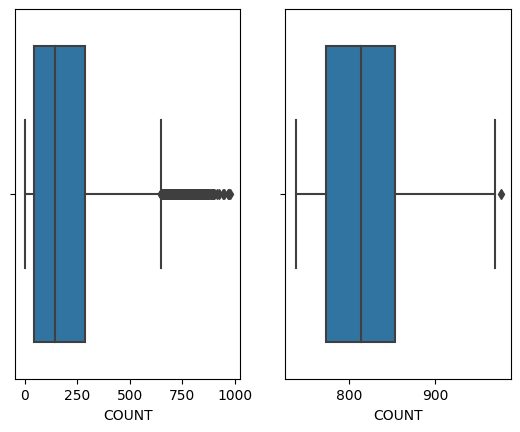

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 2)
sns.boxplot(x=df_table.to_pandas()['COUNT'], ax=axes[0])
sns.boxplot(x=df_without_outlier.to_pandas()['COUNT'], ax=axes[1])
plt.show()

### Correlation Analysis

* Section cover snowpark default option to calculate correlation score
* Also provides code snippet - by converting to pandas dataframe

In [15]:
#Correlation
column_list = ["temp","atemp","casual","registered","humidity","windspeed","count"]
for i in range(0, len(column_list) - 1):
    for j in range( i + 1, len(column_list)):
        correlation = df_without_outlier.stat.corr(column_list[i], column_list[j])
        text = f"Correlation between {column_list[i]} and {column_list[j]} is {correlation}"
        print(text)

Correlation between temp and atemp is 0.8867069954671704
Correlation between temp and casual is 0.27439586514534764
Correlation between temp and registered is -0.11344260141130262
Correlation between temp and humidity is -0.22209903468060024
Correlation between temp and windspeed is -0.00282142677568521
Correlation between temp and count is 0.090925961635169
Correlation between atemp and casual is 0.2147513221104753
Correlation between atemp and registered is -0.0797053102397002
Correlation between atemp and humidity is -0.13160630310282323
Correlation between atemp and windspeed is -0.029077657967140087
Correlation between atemp and count is 0.08216007024581092
Correlation between casual and registered is -0.5753920258798173
Correlation between casual and humidity is -0.4627632395376554
Correlation between casual and windspeed is 0.016935938842728943
Correlation between casual and count is 0.13515372607423487
Correlation between registered and humidity is 0.230233618846889
Correlation

<Axes: >

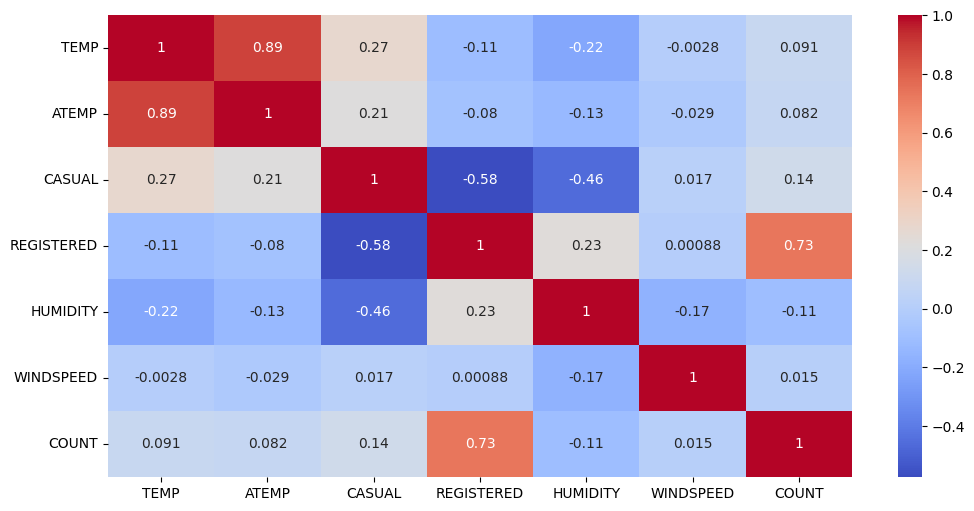

In [16]:
column_list_upper = [column.upper() for column in column_list]
df_corr = df_without_outlier.select(*column_list_upper)
corr_matrix = df_corr.to_pandas().corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

### Filling 0's In windspeed -  Using Mean

* Code demostrates filling in missing values in Windspeed using Mean

In [17]:
df = session.table("BSD_TRAINING")
df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATETIME"           |"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------
|2011-01-01 00:00:00  |1         |0          |0             |1          |9.84    |14.395   |81          |0.0          |3         |13            |16       |
|2011-01-01 01:00:00  |1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |8         |32            |40       |
|2011-01-01 02:00:00  |1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |5         |27            |32       |
|2011-01-01 03:00:00  |1         |0          |0             |1  

In [18]:
print(f"Zero Values in windspeed column is {df_table.filter(df_table['WINDSPEED']==0).count()}")

Zero Values in windspeed column is 1313


In [19]:
wind_speed_mean = df_table.select(mean("windspeed")).collect()[0][0]
print(wind_speed_mean)

12.7993954069447


In [20]:
from snowflake.snowpark.functions import iff, avg
df_train = df_table.replace({0:wind_speed_mean}, subset=["windspeed"])
df_train.show()
df_train.write.mode("overwrite").save_as_table("model_data")

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"       |"CASUAL"  |"REGISTERED"  |"COUNT"  |"DATETIME"           |"HOUR"  |"MONTH"  |"DATE"      |"WEEKDAY"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |12.7993954069447  |3         |13            |16       |2011-01-01 00:00:00  |0       |1        |2011-01-01  |6          |
|1         |0          |0             |1          |9.02    |13.635   |80          |12.7993954069447  |8         |32            |40       |2011-01-01 01:00:00  |1       |1        |2

### LINEAR REGRESSION MODEL - Using Sklearn
* Section demonstrates how traditionally ML models can be built & deployed using Stored Procedures
* Section was included to explain how SNOWPARK ML eases model building process in the following section

If Scikit-learn is not installed already, install with:
```bash
pip install -U scikit-learn
```

In [23]:
# Prepare your stage to save our models to:
session.sql("CREATE STAGE IF NOT EXISTS SNOWPARK_DEFINITIVE_GUIDE.MY_SCHEMA.SNOWPARK_TEST_STAGE").collect()

[Row(status='Stage area SNOWPARK_TEST_STAGE successfully created.')]

In [27]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from snowflake.snowpark.types import StringType
import numpy as np
import joblib

def fit_linear_regressor(session:Session,
    table_name: str, feature_list: list, target_col: str, category_variable_list: list)->str:
    model = LinearRegression()
    df = session.table(table_name).to_pandas()

    for column in category_variable_list:
        df[column] = df[column].astype("category")
    y_lables_log = np.log1p(df[target_col])
    x_train, x_test, y_train, y_test = train_test_split(df, y_lables_log, test_size=0.3, random_state=42)

    test_df = session.create_dataframe(x_test)
    test_df.write.mode("overwrite").save_as_table("lr_test")

    model.fit(x_train[feature_list], y_train)
    joblib.dump(model, '/tmp/lr_model.joblib')

    # upload into my_internal_stage in Snowflake
    session.file.put(
        "/tmp/lr_model.joblib", "@snowpark_test_stage", auto_compress=False, overwrite=True
    )
    return 'Success'

session.sproc.register(
    func = fit_linear_regressor,
    is_permanent = True,
    name = 'fit_linear_regressor',
    replace = True,
    return_type = StringType(),
    stage_location = '@snowpark_test_stage',
    packages=[
            'snowflake-snowpark-python',
            'scikit-learn',
            'joblib',
            'numpy'
    ]
)

feature_list = ["SEASON", "HOLIDAY", "WORKINGDAY", "WEATHER", "WEEKDAY", "HOUR", "HUMIDITY", "MONTH", "TEMP", "ATEMP", "WINDSPEED"]
category_variable_list = ["HOUR","WEEKDAY","MONTH","SEASON","WEATHER","HOLIDAY","WORKINGDAY"]
table_name = "model_data"
target_column = "COUNT"
session.call("fit_linear_regressor", table_name, feature_list, target_column, category_variable_list)


The version of package 'scikit-learn' in the local environment is 1.3.2, which does not fit the criteria for the requirement 'scikit-learn'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'joblib' in the local environment is 1.3.2, which does not fit the criteria for the requirement 'joblib'. Your UDF might not work when the package version is different between the server and your local environment.


'Success'

In [30]:
session.clear_imports()
session.clear_packages()

session.add_import("@snowpark_test_stage/lr_model.joblib")

from snowflake.snowpark.types import PandasDataFrame, PandasSeries



def lr_predict_udf(df: PandasDataFrame[float, float, float, float, float, float, float, float, float, float, float]) -> PandasSeries[int]:
    import joblib, sys, os
    import pandas as pd

    import_dir = sys._xoptions.get("snowflake_import_directory")
    with open(os.path.join(import_dir, 'lr_model.joblib'), 'rb') as model_file:
        model = joblib.load(model_file)

    return model.predict(df)

session.udf.register(
    func = lr_predict_udf,
    is_permanent = True,
    name = 'lr_predict_udf',
    replace = True,
    stage_location = '@snowpark_test_stage',
    packages=[
            'snowflake-snowpark-python',
            'scikit-learn',
            'joblib']

)

The version of package 'scikit-learn' in the local environment is 1.3.2, which does not fit the criteria for the requirement 'scikit-learn'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'joblib' in the local environment is 1.3.2, which does not fit the criteria for the requirement 'joblib'. Your UDF might not work when the package version is different between the server and your local environment.


In [33]:
result_df = pd.DataFrame(session.sql(f'''
    select lr_predict_udf("SEASON", "HOLIDAY", "WORKINGDAY", "WEATHER", "WEEKDAY", "HOUR", "HUMIDITY", "MONTH", "TEMP", "ATEMP", "WINDSPEED" ) as predict
    from lr_test
''').collect())

from sklearn.metrics import (
explained_variance_score, 
max_error, 
mean_absolute_error, 
mean_squared_error, 
mean_squared_log_error,
median_absolute_error, 
r2_score, 
mean_poisson_deviance,
mean_gamma_deviance, 
mean_absolute_percentage_error, 
d2_absolute_error_score,
d2_pinball_score,
d2_tweedie_score
)


df_test = session.table("lr_test")
y_true = df_test.select(["COUNT"]).to_pandas()
print ("Explained Variance Score For Linear Regression: ", explained_variance_score(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("Max Error For Linear Regression: ", max_error(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("MAE For Linear Regression: ", mean_absolute_error(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("MSE For Linear Regression: ", mean_squared_error(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("MSLE For Linear Regression: ", mean_squared_log_error(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("MDAE For Linear Regression: ", median_absolute_error(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("R2 For Linear Regression: ", r2_score(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("Mean Poisson Deviance For Linear Regression: ", mean_poisson_deviance(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("Mean Gamma Deviance For Linear Regression: ", mean_gamma_deviance(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("Mean Absolute Percentage ErrorD For Linear Regression: ", mean_absolute_percentage_error(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("D2 Absolute Error Score For Linear Regression: ", d2_absolute_error_score(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("D2 Pinball Score For Linear Regression: ", d2_pinball_score(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))
print ("D2 Tweedie Score For Linear Regression: ", d2_tweedie_score(np.exp(np.log1p(y_true["COUNT"])),np.exp(result_df["PREDICT"])))


Explained Variance Score For Linear Regression:  -0.2538003732762937
Max Error For Linear Regression:  957.9142799713436
MAE For Linear Regression:  160.33520121823068
MSE For Linear Regression:  50632.02232570326
MSLE For Linear Regression:  3.0178036148751954
MDAE For Linear Regression:  113.4131591025766
R2 For Linear Regression:  -0.55597921793249
Mean Poisson Deviance For Linear Regression:  416.1912413074655
Mean Gamma Deviance For Linear Regression:  7.46955143010058
Mean Absolute Percentage ErrorD For Linear Regression:  2.9894440961164515
D2 Absolute Error Score For Linear Regression:  -0.17385062814935615
D2 Pinball Score For Linear Regression:  -0.17385062814935615
D2 Tweedie Score For Linear Regression:  -0.5559791147634778


### LINEAR REGRESSION MODEL - Using SNOWPARK ML Package
* Section demonstates how SNOWPARKML library can be utilized to build ML models
* Also delineates how it closely resembles Sklearn coding paradigm

In [35]:
df = df_table.drop("DATETIME","DATE")
df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"HOUR"  |"MONTH"  |"WEEKDAY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |0.0          |3         |13            |16       |0       |1        |6          |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |8         |32            |40       |1       |1        |6          |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |5         |27            |32       |2       |1        |6          |
|1        

In [36]:
CATEGORICAL_COLUMNS = ["SEASON", "WEATHER"]
CATEGORICAL_COLUMNS_OHE = ["SEASON_OE", "WEATHER_OE"]
MIN_MAX_COLUMNS = ["TEMP", "ATEMP"]
FEATURE_LIST = [ "HOLIDAY", "WORKINGDAY", "WEEKDAY", "HOUR", "HUMIDITY", "MONTH", "TEMP", "ATEMP", "WINDSPEED"]

LABEL_COLUMNS = ['COUNT']
OUTPUT_COLUMNS = ['PREDICTED_COUNT']

PIPELINE_FILE = 'preprocessing_pipeline.joblib'
preprocessing_pipeline = joblib.load(PIPELINE_FILE)

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessing_pipeline.joblib'

In [ ]:
# Split the data into train and test sets
bsd_train_df, bsd_test_df = df.random_split(weights=[0.7, 0.3], seed=0)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(bsd_train_df).transform(bsd_train_df)
test_df = preprocessing_pipeline.transform(bsd_test_df)
train_df.show()
test_df.show()

In [ ]:
from snowflake.ml.modeling.linear_model import LinearRegression


regressor = LinearRegression(
    input_cols=CATEGORICAL_COLUMNS_OHE+FEATURE_LIST,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
regressor.fit(train_df)

# Predict
result = regressor.predict(test_df)
result.show()

In [ ]:

from snowflake.ml.modeling.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_absolute_percentage_error, d2_absolute_error_score, d2_pinball_score

mse = mean_squared_error(df=result, y_true_col_names="COUNT", y_pred_col_names="PREDICTED_COUNT")
evs = explained_variance_score(df=result, y_true_col_names="COUNT", y_pred_col_names="PREDICTED_COUNT")
mae = mean_absolute_error(df=result, y_true_col_names="COUNT", y_pred_col_names="PREDICTED_COUNT")
mape = mean_absolute_percentage_error(df=result, y_true_col_names="COUNT", y_pred_col_names="PREDICTED_COUNT")
d2aes = d2_absolute_error_score(df=result, y_true_col_names="COUNT", y_pred_col_names="PREDICTED_COUNT")
d2ps = d2_pinball_score(df=result, y_true_col_names="COUNT", y_pred_col_names="PREDICTED_COUNT")

print(f"Mean squared error: {mse}")
print(f"explained_variance_score: {evs}")
print(f"mean_absolute_error: {mae}")
print(f"mean_absolute_percentage_error: {mape}")
print(f"d2_absolute_error_score: {d2aes}")
print(f"d2_pinball_score: {d2ps}")
